INSTALLING LIBRARIES (something conflicts, need to restart the session)

In [16]:
!pip install gensim

IMPORTING NECESSARY LIBRARIES

In [17]:
import os
import re
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SpatialDropout1D, LSTM, Dropout,GRU, Dense, Bidirectional,GlobalAveragePooling1D,Flatten,BatchNormalization
)
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer

DATASET IMPORT

DATASETS

In [18]:
DATA_PATH       = "https://raw.githubusercontent.com/samupitto/GURT/refs/heads/main/Gurt_Dataset.csv" #custom dataset (train/test)
ds              = pd.read_csv("hf://datasets/nikesh66/Slang-Dataset/slang_tweets.csv")  # test dataset
raw_labels      = ds["Slang (yes/no)"]
y_true          = np.array([1 if lab.lower()=="yes" else 0 for lab in raw_labels]) #turning labels of the test dataset into

COSTANTS

In [19]:

EMBEDDING_DIM   = 100
MAX_VOCAB_SIZE  = 100000
W2V_EPOCHS      = 20
RNN_EPOCHS      = 20
TEST_SIZE       = 0.2
RANDOM_STATE    = 42
L2_REG          = 1e-4
SPATIAL_DROPOUT = 0.2
DROPOUT_RATE    = 0.5
BTC_SIZE        = 32
THRESHOLD       = 0.6
N_FOLDS         = 5

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")

#SLANG DATA:
Custom Dataset created by web scraping the Slang Online Dictionary (http://onlineslangdictionary.com/) for the positive labels. The negative examples are taking from the following dataset: https://www.kaggle.com/datasets/mfekadu/sentences.

**The user has the opportunity to choose if to clean the dataset and which embedding to use**

In [20]:

CLEAN   = int(input("1: CLEAN, 0: NOT CLEAN"))
W2V = int(input("W2V EMBEDDINGS: 1, TF_IDF: 0"))

df=pd.read_csv(DATA_PATH)
sentences=df["sentence"]
labels=df["label"]


1: CLEAN, 0: NOT CLEAN0
W2V EMBEDDINGS: 1, TF_IDF: 01


FUNCTIONS

In [21]:
def clean_text(text):
    return re.sub(r"[.?!,<>()']", "", text.lower())


def get_sentence_embedding(padded_sentence, embedding_matrix):
    vecs = [embedding_matrix[idx] for idx in padded_sentence if idx != 0 and idx < len(embedding_matrix)]
    return np.mean(vecs, axis=0) if vecs else np.zeros(embedding_matrix.shape[1])




SPLIT TRAIN/TEST

In [45]:


X_train_sent, X_test_sent, y_train, y_test = train_test_split(
    sentences.values,
    labels.values,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels.values
)

In [46]:
X_train_sent, X_val_sent, y_train, y_val = train_test_split(
    X_train_sent,
    y_train,
    test_size=0.10,
    random_state=RANDOM_STATE,
    stratify=y_train
)

#CLEAN AND TOKENIZE
we noticed that on the slang dataset the best performances are obtained without cleaning the sentences.

In [51]:
if CLEAN==1:
  X_train_sent = [clean_text(s) for s in X_train_sent]
  X_val_sent   = [clean_text(s) for s in X_val_sent]
  X_test_sent  = [clean_text(s) for s in X_test_sent]
  ds["Tweet"]  = ds["Tweet"].apply(clean_text)

train_tokens   = [s.split() for s in X_train_sent]
val_tokens     = [s.split() for s in X_val_sent]
test_tokens     = [s.split() for s in X_test_sent]
new_ds_tokens  = [s.split() for s in ds["Tweet"].values]


In [30]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_tokens)

We calculate the mean amount of tokens per sentence, it will be useful to know which len to pad/truncate

In [31]:
sentence_lengths = [len(train_tokens[sentence]) for sentence in range(len(train_tokens))]

# 2. Compute average length
average_length = np.mean(sentence_lengths)

# 3. Compute length that covers 90% of the sentences (90th percentile)
length_95_percentile = int(np.percentile(sentence_lengths, 95))

# 4. Print results
print(f"Average sentence length: {average_length:.2f} tokens")
print(f"Maximum sentence length to cover 90% of data: {length_95_percentile} tokens")
MAX_SEQ_LEN     = length_95_percentile

Average sentence length: 9.55 tokens
Maximum sentence length to cover 90% of data: 16 tokens


#Word2Vec Training


In [32]:
if W2V==1:
  w2v_model = Word2Vec(
      sentences=train_tokens,
      vector_size=EMBEDDING_DIM,
      window=5,
      min_count=2,
      workers=4,
      epochs=W2V_EPOCHS
  )



EMBEDDING MATRIX

In [33]:
if W2V==1:

  word_index       = tokenizer.word_index
  num_words        = min(MAX_VOCAB_SIZE, len(word_index) + 1)
  embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
  for word, i in word_index.items():
      if i < num_words and word in w2v_model.wv:
          embedding_matrix[i] = w2v_model.wv[word]

In [34]:
print(embedding_matrix.shape)

(34545, 100)


PADDING SENTENCES

In [35]:

def to_padded(tokens_list):
    seqs = tokenizer.texts_to_sequences(tokens_list)
    return pad_sequences(seqs, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

In [52]:
X_train    = to_padded(train_tokens)
X_val      = to_padded(val_tokens)
X_test= to_padded(test_tokens)
new_ds_val = to_padded(new_ds_tokens)

#TF-IDF

In [ ]:
if W2V==0:
  print("tf-idf")
  tfidf = TfidfVectorizer(
      max_features=MAX_VOCAB_SIZE-1,  # leave room for PAD at index 0
      stop_words='english',           # optional
      ngram_range=(1,1)               # unigrams only
  )
  X_tfidf = tfidf.fit_transform(sentences)  # shape (N, V) where V ≤ MAX_VOCAB_SIZE-1

  # 2) Grab the IDF array and vocabulary mapping
  idf        = tfidf.idf_                         # shape (V,)
  tfidf_vocab = tfidf.vocabulary_   # dict: word -> column index (0…V-1)

  # 3) Build your embedding matrix = one IDF weight per token index
  num_words       = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
  embedding_dim   = 1    # one scalar weight = the IDF
  embedding_matrix = np.zeros((num_words, embedding_dim), dtype=np.float32)

  for word, i in tokenizer.word_index.items():
      if i >= num_words:
          continue
      if word in tfidf_vocab:
          embedding_matrix[i, 0] = idf[tfidf_vocab[word]]
      else:
          # OOV or stop‐word: leave as zero (or set to mean(idf) if you prefer)
          embedding_matrix[i, 0] = 0.0

# SVD OF SENTENCES
We use singular value decomposition to recude the dimension of the embedding vector in order to plot it on a 2d graph to enanche vizualization.
In order to do so we first compute the embedding of each sentence by concatenating the embedding of each word

In [ ]:



if W2V==1:

  # 2. Generate all sentence embeddings
  sentence_embeddings = np.array([
      get_sentence_embedding(sentence, embedding_matrix)
      for sentence in X_train  # X_train = padded sequences
  ])

  # 3. Reduce dimensionality to 2D using SVD
  svd = TruncatedSVD(n_components=2)
  reduced = svd.fit_transform(sentence_embeddings)

  # 4. Plot with colors based on label (y_train must be defined)
  plt.figure(figsize=(12, 12))
  colors = ['red' if y == 1 else 'blue' for y in y_train]
  plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, alpha=0.5, s=8)
  plt.title("2D Projection of Sentence Embeddings (colored by label)")
  plt.grid(True)
  plt.show()

In [ ]:
seq_embs = embedding_matrix[X_train]
flat_embs = seq_embs.reshape(len(seq_embs), -1)

svd= TruncatedSVD(n_components=2)
reduced_flat = svd.fit_transform(flat_embs)

# 4. Plot with colors based on label (y_train must be defined)
plt.figure(figsize=(12, 12))
colors = ['red' if y == 1 else 'blue' for y in y_train]
plt.scatter(reduced_flat[:, 0], reduced_flat[:, 1], c=colors, alpha=0.5, s=8)
plt.title("2D Projection of Sentence Embeddings (colored by label)")
plt.grid(True)
plt.show()

In [37]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


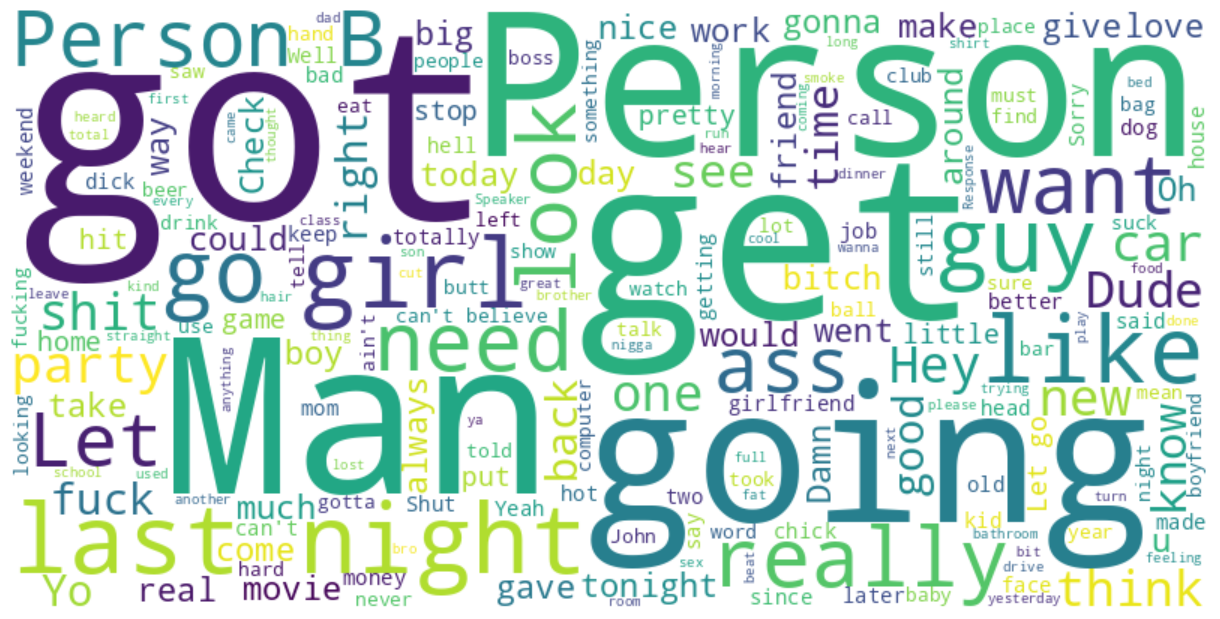

In [40]:

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1) Ensure NLTK’s English stopwords are available
nltk.download('stopwords')


label1_series = df.loc[labels == 1, "sentence"]

# 3) Build the corpus string
corpus_label1 = " ".join(label1_series.astype(str))

# 4) Get classic English stopwords
english_stopwords = set(stopwords.words("english"))

# 5) Generate the word cloud
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=english_stopwords,
    max_words=200
).generate(corpus_label1)

# 6) Display it
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


#BASELINE MODEL
We start with an attempt to train of using the simplest model possible, a single perceptron, in order to determine the expected baseline of the problem

In [41]:
print(embedding_matrix.shape[0])
print(num_words)

34545
34545


In [60]:
baseline_model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=embedding_matrix,
        trainable=False,
        embeddings_regularizer=regularizers.l2(L2_REG)
    ),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [61]:
baseline_model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
    metrics=["accuracy"]
)
baseline_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     3,454,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,500 (13.18 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,454,500 (13.18 MB)

In [62]:
history = baseline_model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=BTC_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/2
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8639 - loss: 0.3126 - val_accuracy: 0.9127 - val_loss: 0.2181
Epoch 2/2
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9107 - loss: 0.2139 - val_accuracy: 0.9124 - val_loss: 0.2168


In [63]:
baseline_model.evaluate(X_test, y_test)

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9153 - loss: 0.2104


[0.20872525870800018, 0.9149425029754639]

#BRIEF DISCUSSION OF THE PERCEPTRON
We observe that the baseline model already have great performances, that means that our datapoints are linearly divisible (as we can see on the graph) and there is probably no need for more complex architectures

#DECISION BOUNDARY
we proceed to show the decision boundary of our perceptron, to do so we need to plot the line y=Wx+b

In [64]:
W, b = baseline_model.layers[-1].get_weights()  # Dense layer weights

W_2D = svd.components_ @ W

w1, w2 = W_2D.flatten()
bias = b[0]
x_vals = np.linspace(reduced_flat[:, 0].min(), reduced_flat[:, 0].max(), 200)

# Handle the case where w2 is close to zero to avoid division errors
if np.isclose(w2, 0):
    # If w2 is close to zero, the boundary is a vertical line x = -bias / w1
    y_vals = np.linspace(reduced_flat[:, 1].min(), reduced_flat[:, 1].max(), 200)
    x_vals = np.full_like(y_vals, -bias / w1)
else:
    y_vals = -(w1 * x_vals + bias) / w2



"""

plt.figure(figsize=(12, 12))
if not np.all(np.isclose(x_vals, -bias / w1)):
    plt.plot(x_vals, y_vals, color='black', linewidth=2, label='Decision boundary')
elif not np.isclose(w1, 0): # If w1 is not zero, it's a vertical line
     plt.axvline(x=-bias/w1, color='black', linewidth=2, label='Decision boundary')
colors = ['red' if y == 1 else 'blue' for y in y_train]
plt.scatter(reduced_flat[:, 0], reduced_flat[:, 1], c=colors, alpha=0.5, s=8)
plt.title("2D Projection of Sentence Embeddings (colored by label)")
plt.grid(True)
plt.show()"""


NameError: name 'svd' is not defined

In [ ]:
x_min, x_max = reduced_flat[:,0].min(), reduced_flat[:,0].max()
y_min, y_max = reduced_flat[:,1].min(), reduced_flat[:,1].max()

# Optionally add a small margin:
x_pad = (x_max - x_min) * 0.05
y_pad = (y_max - y_min) * 0.05
x_min, x_max = x_min - x_pad, x_max + x_pad
y_min, y_max = y_min - y_pad, y_max + y_pad

# 2) Plot everything
plt.figure(figsize=(12,12))

# Scatter first
colors = ['red' if y==1 else 'blue' for y in y_train]
plt.scatter(reduced_flat[:,0], reduced_flat[:,1], c=colors, alpha=0.5, s=8)

# Decision boundary
if not np.allclose(x_vals, -bias/w1):
    plt.plot(x_vals, y_vals, 'k-', linewidth=2, label='Decision boundary')
elif not np.isclose(w1, 0):
    plt.axvline(x=-bias/w1, color='k', linewidth=2, label='Decision boundary')

# 3) Re-apply the original limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title("2D Projection of Sentence Embeddings (colored by label)")
plt.grid(True)
plt.legend()
plt.show()

#LSTM MODEL
even if a simple architecture as the perceptron already works well for our dataset, we try to implement a more suited architecture, using LSTM layers.

In [81]:
model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=embedding_matrix, #we use our pretrained weights
        trainable=False,
    ),
    SpatialDropout1D(SPATIAL_DROPOUT),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])


COMPILING MODEL

In [82]:


model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
    metrics=["accuracy"]

)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     3,454,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,500 (13.18 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,454,500 (13.18 MB)

TRAINING

In [83]:
history = model.fit(
    X_train, y_train,
    epochs=7,
    batch_size=BTC_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/7
783/783 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8809 - loss: 0.2883 - val_accuracy: 0.9253 - val_loss: 0.1810
Epoch 2/7
783/783 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9181 - loss: 0.1960 - val_accuracy: 0.9300 - val_loss: 0.1749
Epoch 3/7
783/783 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9252 - loss: 0.1805 - val_accuracy: 0.9393 - val_loss: 0.1661
Epoch 4/7
783/783 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9297 - loss: 0.1736 - val_accuracy: 0.9357 - val_loss: 0.1714
Epoch 5/7
783/783 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9346 - loss: 0.1602 - val_accuracy: 0.9318 - val_loss: 0.1626
Epoch 6/7
783/783 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9405 - loss: 0.1525 - val_accuracy: 0.9368 - val_loss: 0.1563
Epoch 7/7
783/783 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9406 - loss: 0.1500 - val_accuracy: 0.9379 - val_loss: 0.1519


PLOTTING LOSS AND ACCURACY

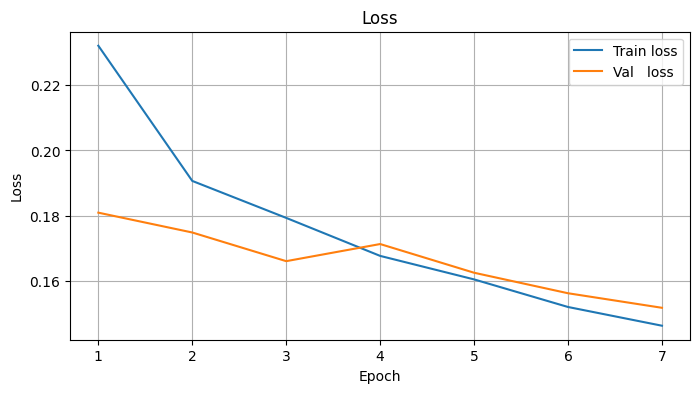

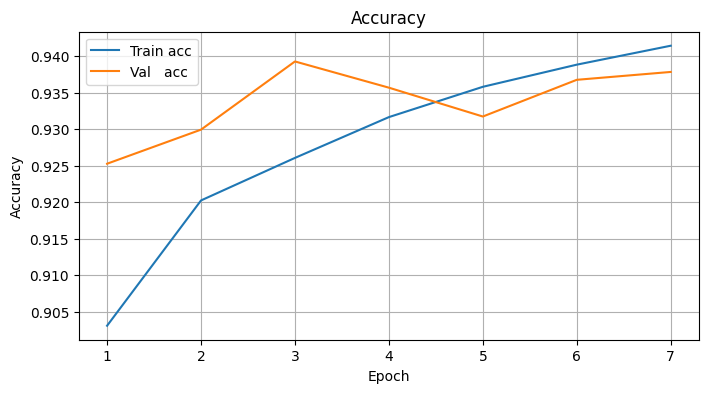

218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9340 - loss: 0.1579
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7276 - loss: 0.4838

External 5-Fold Cross-Validation:
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7146 - loss: 0.4779
 Fold 1: Acc=0.733
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7238 - loss: 0.5072
 Fold 2: Acc=0.720
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7345 - loss: 0.4893
 Fold 3: Acc=0.738
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7149 - loss: 0.4828
 Fold 4: Acc=0.727
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7506 - loss: 0.4604
 Fold 5: Acc=0.742

Average external (over 5 folds): Acc=0.732±0.008, 


In [89]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, history.history['loss'],     label='Train loss')
plt.plot(epochs, history.history['val_loss'], label='Val   loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

plt.figure(figsize=(8,4))
plt.plot(epochs, history.history['accuracy'],     label='Train acc')
plt.plot(epochs, history.history['val_accuracy'], label='Val   acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.show()


# 11) Final evaluation with THRESHOLD on internal
model.evaluate(X_test,y_test, batch_size=BTC_SIZE)


#-------------------------------------------------------------------------------
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
accs=[]

print(f"\nExternal {N_FOLDS}-Fold Cross-Validation:")
for fold, (_, test_idx) in enumerate(skf.split(new_ds_val, y_true), start=1):
    X_fold = new_ds_val[test_idx]
    y_fold = y_true[test_idx]
    loss,acc = model.evaluate(X_fold,y_fold, batch_size=BTC_SIZE)

    accs.append(acc)

    print(f" Fold {fold}: Acc={acc:.3f}")

print(f"\nAverage external (over {N_FOLDS} folds): "
      f"Acc={np.mean(accs):.3f}±{np.std(accs):.3f}, ")




In [92]:
acc_ext_p,loss_ext_p=baseline_model.evaluate(new_ds_val,y_true, batch_size=BTC_SIZE)


acc_ext_p,loss_ext_p=baseline_model.evaluate(new_ds_val,y_true, batch_size=BTC_SIZE)


print(f"External single split — Acc: {acc_ext_p:.3f}")

print(f"Comparison LSTM-Perceptron on external Dataset — LSTM>Logistic_Regression: {acc-acc_ext_p:.3f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7485 - loss: 0.5100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7485 - loss: 0.5100
External single split — Acc: 0.508
Comparison LSTM-Perceptron on external Dataset — LSTM>Logistic_Regression: 0.234


#USING LIME FOR MODEL EXPLAINABILITY
even if we already possess an interpretable model that does good prediction over our dataset, we would like to understand how our more complex LSTM takes decision.
For this purpuse we use LIME (Local Interpretable Model-Agnostic Explanations).

LIME creates an interpretable model that locally explains instances, by training it over perturbated version of our input (masking words in this case) by using our model prediction as labels, locally distilling it.

In [95]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d83db2e2f3d28f4c701a8df6982fd940a37238611d9fc446baa943f93a290f75
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [109]:


from lime.lime_text import LimeTextExplainer


# our two classes for the LSTM model
class_names = ["non-slang", "slang"]

# wrap the trained LSTM so it returns probabilities for both classes
def predict_proba_lstm(texts):
    # optionally clean up the text if required
    if CLEAN == 1:
        texts_proc = [clean_text(t) for t in texts]
    else:
        texts_proc = texts

    # turn words into integer sequences and pad them to a fixed length
    seqs = tokenizer.texts_to_sequences(texts_proc)
    padded = pad_sequences(seqs, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

    # get the model's output (shape = [batch_size, 1]) and flatten to 1D
    probs = model.predict(padded, batch_size=BTC_SIZE).flatten()

    # return a 2D array: probability of non-slang, probability of slang
    return np.vstack([1 - probs, probs]).T

# set up LIME with our class names
explainer = LimeTextExplainer(class_names=class_names)

# ask the user which example they want to inspect
idx = int(input("choose the index: "))
text_instance = X_test_sent[idx]
true_label = y_test[idx]

# generate the LIME explanation for that single sentence
exp = explainer.explain_instance(
    text_instance,
    predict_proba_lstm,
    num_features=10,
    top_labels=1
)

# print out the original sentence and its true label
print("Sentence:", text_instance)
print("True label:", class_names[true_label])

# retrieve and print the baseline value (intercept) from the local linear model
label = exp.available_labels()[0]

print("Base value:", exp.intercept[label])

# show the inline explanation in the notebook
exp.show_in_notebook(text=True)


choose the index: 10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Sentence: George Martins arrangement is lush and intentionally so.
True label: non-slang
Base value: 0.3799156586559799


How to read:
LIME is approximating how words impacts our model decisions. orange highlight are in support of the class we are trying to explain.
The base value is theprobability LIME would guess if no word is present.